In [135]:
#!pip install seaborn
!pip install openpyxl


You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


In [136]:
import pandas as pd
import numpy as np
import random as rd
import time
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

In [137]:
#from google.colab import drive
#drive.mount('/content/drive')
#arquivo = '/content/drive/MyDrive/waterdemand/data/DS_Agua_2017_2022.csv'

In [138]:
file_data = 'DS_Agua_2017_2022.csv'
path_name='data/'
arquivo = f'{path_name}{file_data}'

In [139]:
dataset = pd.read_csv(arquivo, sep =';', encoding = 'latin1', decimal='.')


In [140]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45240 entries, 1 to 45240
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DT_MEDICAO_HORA         45240 non-null  object 
 1   PRECIPITACAO            45240 non-null  float64
 2   PRESSAO_ATMOSFERICA     45240 non-null  float64
 3   TEMPERATURA_DO_AR_C     45240 non-null  float64
 4   UMIDADE_RELATIVA_DO_AR  45240 non-null  float64
 5   VELOCIDADE_VENTO        45240 non-null  float64
 6   VL_MEDICAO              45240 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.8+ MB


In [141]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

DT_MEDICAO_HORA           0
PRECIPITACAO              0
PRESSAO_ATMOSFERICA       0
TEMPERATURA_DO_AR_C       0
UMIDADE_RELATIVA_DO_AR    0
VELOCIDADE_VENTO          0
VL_MEDICAO                0
dtype: int64

In [142]:
dataset.head(10)

,DT_MEDICAO_HORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA_DO_AR_C,UMIDADE_RELATIVA_DO_AR,VELOCIDADE_VENTO,VL_MEDICAO
1,2017-01-01 00:00:00,0.0,1009.5,25.9,75.0,1.3,5016.845991
2,2017-01-01 01:00:00,0.0,1009.6,25.7,76.0,0.9,4998.296902
3,2017-01-01 02:00:00,0.0,1009.2,25.6,76.0,1.1,5013.330096
4,2017-01-01 03:00:00,0.0,1008.4,25.9,77.0,1.7,4972.739746
5,2017-01-01 04:00:00,0.0,1008.1,23.7,85.0,1.7,4921.942265
6,2017-01-01 05:00:00,0.2,1007.5,23.7,87.0,0.4,4838.136258
7,2017-01-01 06:00:00,0.0,1007.3,24.2,88.0,0.5,4833.215005
8,2017-01-01 07:00:00,0.0,1007.3,24.2,87.0,0.7,4795.247653
9,2017-01-01 08:00:00,0.0,1007.7,24.7,85.0,1.0,4763.098501
10,2017-01-01 09:00:00,0.0,1008.5,25.1,83.0,1.2,4715.598748


In [143]:
#tratando o dataframe
df = pd.DataFrame()
df['VL_MEDICAO']=dataset['VL_MEDICAO']

#transformação da série => janela deslizande com 1 passo de tempo
n_time_steps=2
for n_step in range(1,n_time_steps+1,1):
   df['vl-'+str(n_step)]=dataset['VL_MEDICAO'].shift(n_step)  

df['tp-1']=dataset['TEMPERATURA_DO_AR_C']
df['pr-1']=dataset['PRESSAO_ATMOSFERICA']
df['vv-1']=dataset['VELOCIDADE_VENTO']
df['ur-1']=dataset['UMIDADE_RELATIVA_DO_AR']
df['ch-1']=dataset['PRECIPITACAO']

df.dropna(inplace=True)
df.head(5)

,VL_MEDICAO,vl-1,vl-2,tp-1,pr-1,vv-1,ur-1,ch-1
3,5013.330096,4998.296902,5016.845991,25.6,1009.2,1.1,76.0,0.0
4,4972.739746,5013.330096,4998.296902,25.9,1008.4,1.7,77.0,0.0
5,4921.942265,4972.739746,5013.330096,23.7,1008.1,1.7,85.0,0.0
6,4838.136258,4921.942265,4972.739746,23.7,1007.5,0.4,87.0,0.2
7,4833.215005,4838.136258,4921.942265,24.2,1007.3,0.5,88.0,0.0


In [144]:
dataset.head(5)

,DT_MEDICAO_HORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA_DO_AR_C,UMIDADE_RELATIVA_DO_AR,VELOCIDADE_VENTO,VL_MEDICAO
1,2017-01-01 00:00:00,0.0,1009.5,25.9,75.0,1.3,5016.845991
2,2017-01-01 01:00:00,0.0,1009.6,25.7,76.0,0.9,4998.296902
3,2017-01-01 02:00:00,0.0,1009.2,25.6,76.0,1.1,5013.330096
4,2017-01-01 03:00:00,0.0,1008.4,25.9,77.0,1.7,4972.739746
5,2017-01-01 04:00:00,0.0,1008.1,23.7,85.0,1.7,4921.942265


In [145]:
  #Split dataset in treinam /  75% treinam  25% test
  nlinhas = int(np.round(df.shape[0] *0.75)) # 
  
  max_size_train_split = int(np.round(nlinhas / 5)) 
  max_size__test_split = int(np.round((df.shape[0] - nlinhas) / 5))
  size_split = 5
  
  X_train = df.iloc[0:nlinhas,1:6 + n_time_steps]
  y_train = df.iloc[0:nlinhas,0].values

  X_test = df.iloc[nlinhas:dataset.shape[0],1: 6 + n_time_steps] 
  y_test = df.iloc[nlinhas:dataset.shape[0],0].values


In [146]:
scX = StandardScaler()
scY = StandardScaler()
X_train = scY.fit_transform(X_train)
y_train = scY.fit_transform(y_train.reshape(-1,1))

In [147]:
  # Armazena a hora de início da execução do Treinamento
  Hora_Inicio = time.time()

In [148]:
from sklearn.model_selection import TimeSeriesSplit
# Validados cruzado para séries temporais
ts_cv = TimeSeriesSplit(
      n_splits=size_split, # Number of divisions
      max_train_size=max_size_train_split,    # maximum size of each set. of training
      gap=2, # number of samples to exclude between each training and testing set
      test_size=max_size__test_split, # maximum size of each set. of test.
)
param_grid = {
    'hidden_layer_sizes': [(6,12,1),(6,12,24,1),(6,18,1)], # camadas da MLP
    'max_iter': [50, 100, 150, 200], # máximo de iterações
    'activation': [ 'relu','identity'], #função de ativação
    'solver': ['adam'], #algorítmo para otimização do peso
    'alpha': [0.0001, 0.001, 0.05],  # força do alfa de regularização  
}

from sklearn.neural_network import MLPRegressor
modelo = MLPRegressor()

grid = GridSearchCV(modelo, param_grid, n_jobs= -1,scoring='neg_mean_absolute_percentage_error', cv=ts_cv, verbose=1)
grid.fit(np.array(X_train), np.array(y_train))

print(grid.best_params_) 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (6, 12, 1), 'max_iter': 100, 'solver': 'adam'}


In [149]:
#X_test = scX.fit_transform(X_test)
#y_test = StandardScaler().fit_transform(y_test.reshape(-1,1))

In [150]:
scX.fit(X_test)
predict=scY.inverse_transform(grid.predict(scX.transform(X_test)).reshape(-1,1))
predict

# Armazena a hora fim da execução do Treinamento
Hora_Fim = time.time()

#Calcula o tempo de duração da execução do treinamento
Duracao = Hora_Fim - Hora_Inicio

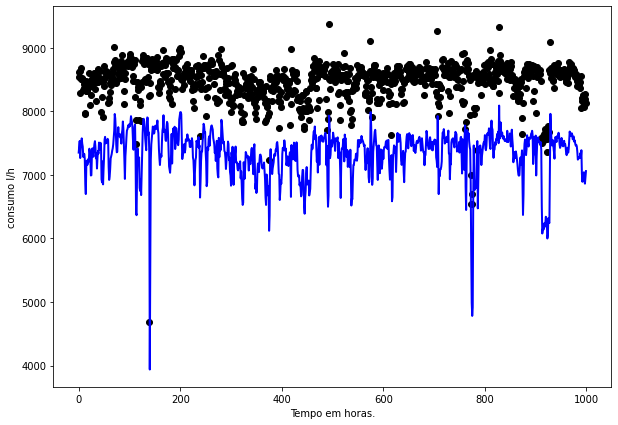

In [151]:
#O gráfico abaixo mostra os valores reais em preto e os valores prditos em azul

#y_test = scY.inverse_transform(y_test)

npredicts=1000
pyplot.figure(figsize=(10,7)) 
pyplot.scatter(np.arange(0,y_test.shape[0],1)[0:npredicts],np.array(y_test)[0:npredicts], color = 'black')
pyplot.plot(np.arange(0,y_test.shape[0],1)[0:npredicts], np.array(predict)[0:npredicts], color = 'blue', linewidth=2)
pyplot.xlabel('Tempo em horas.')
pyplot.ylabel('consumo l/h')
pyplot.show()

In [152]:
predict

array([[7350.88037921],
       [7441.48267268],
       [7534.10665839],
       ...,
       [7706.93773102],
       [8062.29497144],
       [8240.32874281]])

In [153]:
#Validação dos resultados

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

#Erro médio quadrático  (diferença quadrática média entre os valores estimados e o valor verdadeiro) - MSE
mean_squared_error(y_test,predict)



1814425.73703335

In [154]:
#Raiz quadrada do Erro médio - RMSE
np.sqrt(mean_squared_error(y_test, predict))

1347.0062126929297

In [155]:
#Distância absoluta média ou Erro médio absoluto - MAE

median_absolute_error(y_pred=predict, y_true = y_test)

1213.217874384732

In [156]:
#Calcular o MAPE (Erro médio percentual absoluto)
MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100
MAPE

19.84116982943282